In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
def plot_image(image):
  plt.imshow(image, cmap='gray', interpolation='nearest')
  plt.axis('off')
  
def plot_color_image(image):
  plt.imshow(image.astype(np.uint8), interpolation='nearest')
  plt.axis('off')

In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#Convolutional Layer
A neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$, where $f_h$ and $f_w$ are the height and width of the receptive field.

Zero padding: In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs.

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. The distance between two consecutive receptive fields is called the *stride*.

A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i × s_h$ to $i × s_h + f_h – 1$, columns $j × s_w$ to $j × s_w + f_w – 1$, where $s_h$ and $s_w$ are the vertical and horizontal strides.

##Filters
A neuron’s weights can be represented as a small image the size of the receptive field. The following shows two possible sets of weights, called *filters* (or *convolution kernels*).

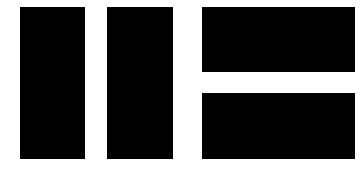

In [25]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
# row=7, column=7, channels=1, num_of_filters=2
# for grayscale, channels=1; for rgb, channels=3

fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plt.subplot(121)
plot_image(fmap[:, :, 0, 0])
plt.subplot(122)
plot_image(fmap[:, :, 0, 1])

The first filter on the left ignores everything except for the central vertical line. The second filter on the right ignore everything except for the central hourizontal line. The following image will be filtered by those two filters,

In [0]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding='SAME')

In [0]:
with tf.Session() as sess:
  output = convolution.eval(feed_dict={X:images})

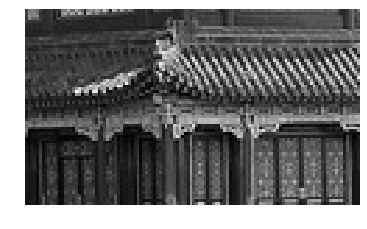

In [29]:
plot_image(images[0, :, :, 0])

Apply the first filter, notice that the vertical white lines get enhanced while the rest gets blurred.

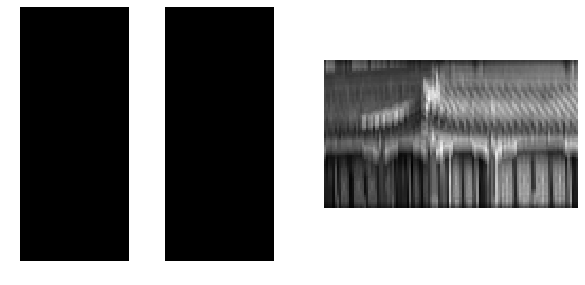

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plot_image(fmap[:, :, 0, 0])
plt.subplot(122)
plot_image(output[0, :, :, 0])

Apply the second filter, notice that the horizontal white lines get enhanced while the rest is blurred out.

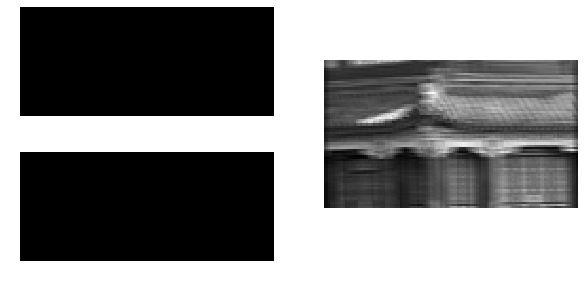

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plot_image(fmap[:, :, 0, 1])
plt.subplot(122)
plot_image(output[0, :, :, 1])

Thus, a layer full of neurons using the same filter gives a *feature map*, which highlights the areas in an image that are most similar to the filter.

##Stacking Multiple Feature Maps
Within one feature map, all neurons share the same parameters (weights and bias term), but different feature maps may have different parameters. A convolutional layer simultaneously applies multiple filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model,
but most importantly it means that once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location.

Specifically, a neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_w$ to $i × s_w + f_w – 1$ and columns $j × s_h$ to $j × s_h + f_h – 1$, across all feature maps (in layer $l – 1$). 

Note that all neurons located in the same row $i$ and column $j$ but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

*Computing the output of a neuron in a convolutional layer*:

$z_{i, j, k}=b_k+ \sum\limits_{u=1}^{f_h}\sum\limits_{v=1}^{f_w}\sum\limits_{k'=1}^{f_{n'}} x_{i', j', k'}\cdot w_{u, v, k', k}$ with 
$
 \left\{
        \begin{array}{ll}
            i'=u\cdot s_h+f_h-1 \\
            j'=v\cdot s_w+f_w-1
        \end{array}
    \right.
$

* $z_{i, j, k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$).
* As explained earlier, $s_h$ and $s_w$ are the vertical and horizontal strides, $f_h$ and $f_w$ are the height and width of the receptive field, and $f_{n′}$ is the number of feature maps in the previous layer (layer $l – 1$).
* $x_{i′, j′, k′}$ is the output of the neuron located in layer $l – 1$, row $i′$, column $j′$, feature map $k′$ (or channel $k′$ if the previous layer is the input layer).
* $b_k$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of the feature map $k$.
* $w_{u, v, k′ ,k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ (relative to the neuron’s receptive field), and feature map $k′$.

##TensorFlow Implementation
In TensorFlow, 

each *input image* is typically represented as a *3D tensor* of shape **[height, width, channels]**. 

A *mini-batch* is represented as a *4D tensor* of shape *[mini-batch size, height, width, channels]*. 

The *weights* of a convolutional layer are represented as a *4D tensor* of shape **[$f_h$ , $f_w$, $f_n$ , $f_{n′}$]**. 

The *bias* terms of a convolutional layer are simply represented as a *1D tensor* of shape **[$f_n$]**.

In [0]:
# Load sample images
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [33]:
dataset.shape
#batch_size= 2 -> 2 images

(2, 427, 640, 3)

In [0]:
# create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line, 1st filter
filters[3, :, :, 1] = 1 # horizontal line, 2nd filter

In [0]:
# create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1, 2, 2, 1], padding='SAME')

* %X% is the input mini-batch (a 4D tensor, as explained earlier).
* **filters** is the set of filters to apply (also a 4D tensor, as explained earlier).
* **strides** is a *four-element* 1D array, where the *two central elements* are the *vertical* and *horizontal strides* ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).
* **padding** must be either **"VALID"** or **"SAME"**:
 * **"VALID"**, the convolutional layer does not use zero padding, and may
ignore some rows and columns at the bottom and right of the input image,
depending on the stride.
 * **"SAME"**, the convolutional layer uses zero padding if necessary. In this
case, the number of output neurons is equal to the number of input neurons
divided by the stride, rounded up (in this example, ceil (13 / 5) = 3). Then
zeros are added as evenly as possible around the inputs.

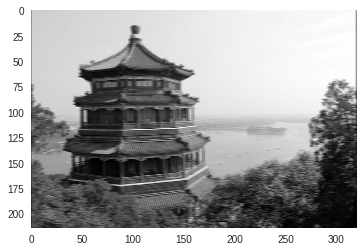

In [37]:
with tf.Session() as sess:
  output = sess.run(convolution, feed_dict={X: dataset})
  
plt.imshow(output[0, :, :, 1], cmap='gray') # plot 1st image's 2nd feature map
plt.grid(False)

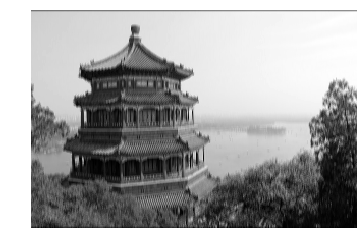

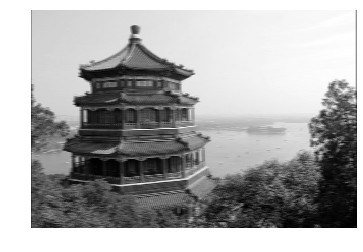

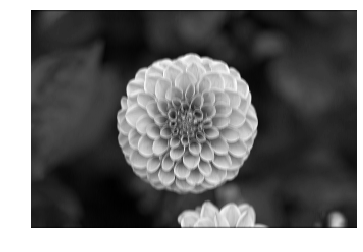

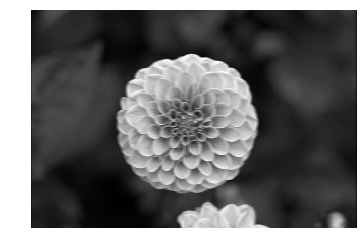

In [39]:
for image_index in (0, 1):
  for feature_map_index in (0, 1):
    plot_image(output[image_index, :, :, feature_map_index])
    plt.show()

Using **tf.layers.conv2d()**,

In [0]:
reset_graph()
X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding='SAME')

In [0]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  init.run()
  output = sess.run(conv, feed_dict={X: dataset})

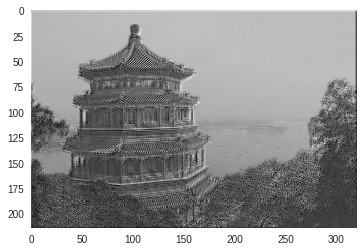

In [44]:
plt.imshow(output[0, :, :, 1], cmap='gray') # 1st image's 2nd feature map
plt.grid(False)

###VALID and SAME padding

In [0]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

In [0]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

If training crashes because of an out-of-memory error, you can try *reducing the mini-batch size*. Alternatively, you can try *reducing dimensionality using a stride*, or *removing a few layers*. Or you can try *using 16-bit floats* instead of 32-bit floats. Or you could *distribute the CNN across multiple devices*.

#Pooling Layer
used to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters.

Reducing the input image size also makes the neural network tolerate a little bit of image shift (*location invariance*)

Pooling layer needs to be defined by its size, the stride, and the padding type, but a pooling neuron has no weights.

A pooling layer typically works on every input channel independently, so the output depth is the same as the input depth. You may alternatively pool over the depth dimension, as we will see next, in which case the image’s spatial dimensions (height and width) remain unchanged, but the number of channels is reduced.

In [0]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 #horizontal line

In [0]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

The **ksize** argument contains the kernel shape along all four dimensions of the input tensor: **[batch size, height, width, channels]**. TensorFlow currently does not support pooling over multiple instances, so the first element of **ksize** must be equal to 1. Moreover, it does not support pooling over both the spatial dimensions (height and width) and the depth dimension, so either **ksize[1]** and **ksize[2]** must both be equal to 1, or **ksize[3]** must be equal to 1.

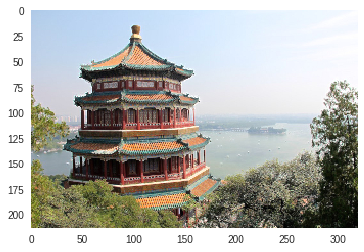

In [49]:
with tf.Session() as sess:
  output = sess.run(max_pool, feed_dict={X: dataset})
  
plt.imshow(output[0].astype(np.uint8)) # plot the output for the 1st image
plt.grid(False)

You can see the difference,

Text(0.5,1,'Max Pooled')

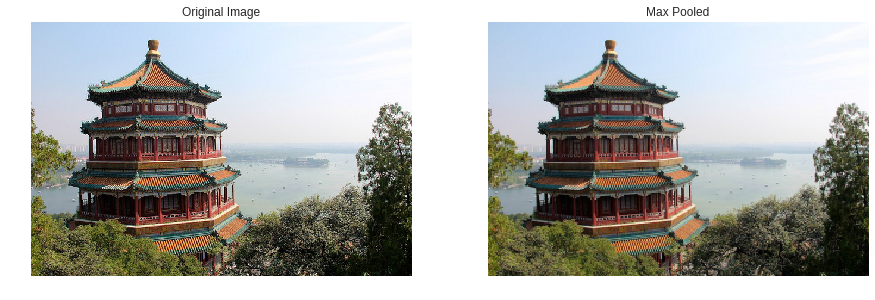

In [60]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plot_color_image(dataset[0])
plt.title('Original Image')
plt.subplot(122)
plot_color_image(output[0])
plt.title('Max Pooled')

create an *average pooling layer*, use **avg_pool()**

In [0]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
avg_pool = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

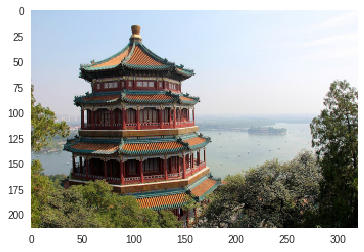

In [58]:
with tf.Session() as sess:
  output_avg = sess.run(avg_pool, feed_dict={X: dataset})
  
plt.imshow(output_avg[0].astype(np.uint8)) # plot the output for the 1st image
plt.grid(False)

Text(0.5,1,'Average Pooled')

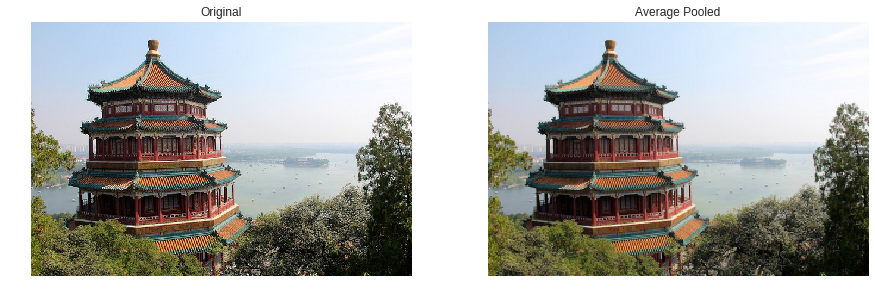

In [61]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plot_color_image(dataset[0])
plt.title('Original')
plt.subplot(122)
plot_color_image(output_avg[0])
plt.title('Average Pooled')


#CNN Architectures
Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on.

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps)

At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction

##TensorFlow Convolution Operations
* **conv1d()** creates a convolutional layer for 1D inputs. This is useful, for example, in natural language processing, where a sentence may be represented as a 1D array of words, and the receptive field covers a few neighboring words.
* **conv3d()** creates a convolutional layer for 3D inputs, such as 3D PET scan.
* **atrous_conv2d()** creates an *atrous convolutional layer*. This is equivalent to using a regular convolutional layer with a filter dilated by inserting rows and columns of zeros (i.e., holes). For example, a 1 × 3 filter equal to **[[1, 2, 3]]** may be dilated with a dilation rate of 4, resulting in a
dilated filter **[[1, 0, 0, 0, 2, 0, 0, 0, 3]]**. This allows the convolutional layer to have a larger receptive field at no computational price and using no extra parameters.
* **conv2d_transpose()** creates a *transpose convolutional layer*, sometimes called a **deconvolutional layer**, which *upsamples* an image. It does so by inserting zeros between the inputs, so you can think of this as a regular convolutional layer using a fractional stride. Upsampling is useful, for example, in image segmentation: in a typical CNN, feature maps get smaller and smaller as you progress through the network, so if you want to output an image of the same size as the input, you need an upsampling layer.
* **depthwise_conv2d()** creates a *depthwise convolutional layer* that applies every filter to every individual input channel independently. Thus, if there are $f_n$ filters and $f_{n′}$ input channels, then this will output $f_n × f_{n′}$ feature maps.
* **separable_conv2d()** creates a *separable convolutional layer* that first acts like a depthwise convolutional layer, then applies a 1 × 1 convolutional layer to the resulting feature maps. This makes it possible to apply filters to arbitrary sets of inputs channels.

#CNN for MNIST

In [0]:
height = 28
width = 28
channels = 1 #gray image
n_inputs = height * width

# 1st convolution layer
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

# 2nd convolution layer
conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = 'SAME'

# pooling for 2nd conv layer
pool3_fmaps = conv2_fmaps

# fully-connected layers
n_fc1 = 64
n_outputs = 10

In [0]:
reset_graph()

In [0]:
# Initialize inputs and outputs
with tf.name_scope('intpus'):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
  # reshape to 2d tensor
  X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
  y = tf.placeholder(tf.int32, shape=[None], name='y')

In [0]:
# set up conv layers
conv1 = tf.layers.conv2d(X_reshaped, 
                         filters=conv1_fmaps, 
                         kernel_size=conv1_ksize,
                         strides=conv1_stride,
                         padding=conv1_pad,
                         activation=tf.nn.relu,
                         name='conv1')
conv2 = tf.layers.conv2d(conv1,
                        filters = conv2_fmaps,
                        kernel_size=conv2_ksize,
                        strides=conv2_stride,
                        padding=conv2_pad,
                        activation=tf.nn.relu,
                        name='conv2')

In [0]:
# create pooling node and flaten to 1D
with tf.name_scope('pool3'):
  pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
  pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

In [0]:
# create fully-connceted layer node
with tf.name_scope('fc1'):
  fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name='fc1')
  

In [0]:
with tf.name_scope('output'):
  logits = tf.layers.dense(fc1, n_outputs, name='outout')
  Y_proba = tf.nn.softmax(logits, name='Y_proba')

In [0]:
with tf.name_scope('train'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
  loss = tf.reduce_mean(xentropy)
  optimizer = tf.train.AdamOptimizer()
  training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope('eval'):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
with tf.name_scope('init_and_save'):
  init = tf.global_variables_initializer()
  saver = tf.train.Saver()

Load the data and start training,

In [91]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [92]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(mnist.train.num_examples // batch_size):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
    print(epoch, 'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
    
  save_path = saver.save(sess, './my_mnist_model')

0 Train accuracy: 0.99 Test accuracy: 0.9775
1 Train accuracy: 0.96 Test accuracy: 0.9813
2 Train accuracy: 1.0 Test accuracy: 0.9876
3 Train accuracy: 0.99 Test accuracy: 0.9883
4 Train accuracy: 1.0 Test accuracy: 0.9884
5 Train accuracy: 0.99 Test accuracy: 0.9904
6 Train accuracy: 1.0 Test accuracy: 0.988
7 Train accuracy: 1.0 Test accuracy: 0.9905
8 Train accuracy: 1.0 Test accuracy: 0.989
9 Train accuracy: 1.0 Test accuracy: 0.9899


###High Accuracy CNN for MNIST
The following CNN is similar to the one defined above, except using stride 1 for the second convolutional layer (rather than 2), with 25% dropout after the second convolutional layer, 50% dropout after the fully connected layer, and trained using early stopping. It achieves around 99.2% accuracy on MNIST. This is not state of the art, but it is not bad. 

In [0]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

In [0]:
reset_graph()

In [0]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")


In [0]:
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [97]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


The **get_model_params()** function gets the model's state (i.e., the value of all the variables), and the **restore_model_params()** restores a previous state. This is used to speed up early stopping: instead of storing the best model found so far to disk, we just save it to memory. At the end of training, we roll back to the best model found.

In [0]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Implementation of early stopping,
* every 100 training iterations, it evaluates the model on the validation set,
* if the model performs better than the best model found so far, then it saves the model to RAM,
* if there is no progress for 100 evaluations in a row, then training is interrupted,
* after training, the code restores the best model found.

In [0]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

In [100]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

Epoch 0, train accuracy: 100.0000%, valid. accuracy: 98.5800%, valid. best loss: 0.059526
Epoch 1, train accuracy: 100.0000%, valid. accuracy: 98.6800%, valid. best loss: 0.042500
Epoch 2, train accuracy: 98.0000%, valid. accuracy: 98.7400%, valid. best loss: 0.042500
Epoch 3, train accuracy: 98.0000%, valid. accuracy: 98.6200%, valid. best loss: 0.038355
Epoch 4, train accuracy: 100.0000%, valid. accuracy: 98.9400%, valid. best loss: 0.035360
Epoch 5, train accuracy: 100.0000%, valid. accuracy: 99.1000%, valid. best loss: 0.035360
Epoch 6, train accuracy: 100.0000%, valid. accuracy: 98.9000%, valid. best loss: 0.035360
Epoch 7, train accuracy: 100.0000%, valid. accuracy: 98.7400%, valid. best loss: 0.035360


KeyboardInterrupt: ignored